In [1]:
import copy
import os
import time
import sqlalchemy
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from dotenv import load_dotenv

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_model import TractsModel

from cities.modeling.zoning_models.zoning_tracts_continuous_interactions_model import TractsModelContinuousInteractions
from cities.utils.data_loader import select_from_data, ZoningDataset
from cities.modeling.waic import compute_waic


from cities.utils.data_grabber import find_repo_root

from cities.modeling.svi_inference import run_svi_inference
from cities.modeling.zoning_models.zoning_tracts_sqm_model import TractsModelSqm

from cities.utils.data_loader import select_from_sql


root = find_repo_root()


smoke_test = "CI" in os.environ
n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

In [2]:
# data loaded from pre-compiled data loader
# as direct db access won't be accessible 
# in CI or to curiuos users without credentials

census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

ct_dataset_read = torch.load(census_tracts_data_path, weights_only=False)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))


#TODO add comments about variables

kwargs = {
    "categorical": ["year", "census_tract", 'university_index', 'downtown_index'],
    "continuous": {
        "housing_units",  
        "housing_units_original",
        "total_value",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        "segregation_original",
        "white_original",
        "parcel_sqm",
        'downtown_overlap', 
        'university_overlap',
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

subset_for_preds = copy.deepcopy(subset)
vars_to_suspend = ["housing_units"]

for var in vars_to_suspend:
    subset_for_preds["continuous"][var] = None


Iterative discussions about the underlying causal structure, data availability and model improvements paired with performance evaluation led to the following baseline causal model. Once we inspect its performance, we will move on to one with pairwise interactions.

/home/rafal/miniconda3/envs/polis-dev/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


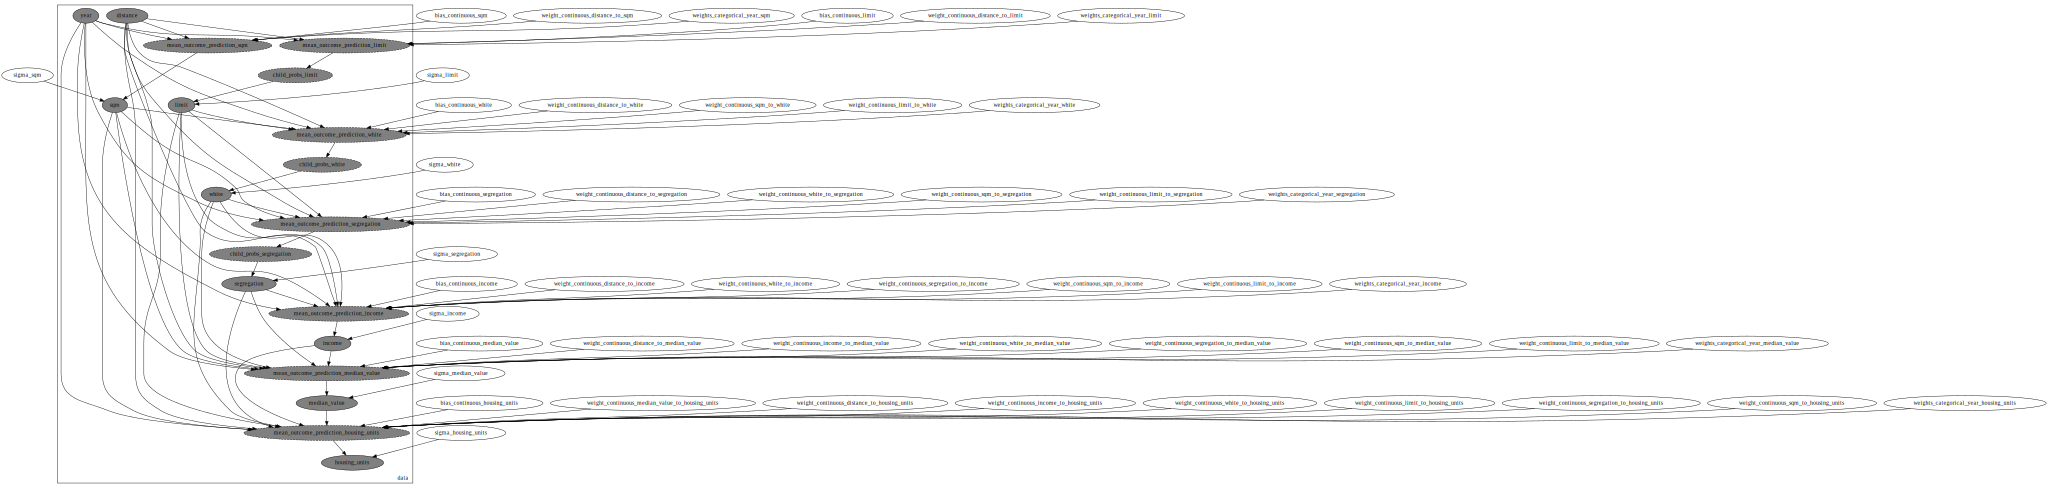

In [3]:
sqm_model = TractsModelSqm(
    **subset, categorical_levels=ct_dataset_read.categorical_levels
)

pyro.render_model(
    lambda: sqm_model(**subset),
    render_deterministic=True, # this requires Pyro >= 1.9.1
    # visualization will be much less informative without rendering
    # the deterministic nodes, especially for model with interactions
)

Basic training-validate performance evaluation can be performed as follows:

In [7]:
def destandardize_housing_units(column):
    mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
    std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

    return (column * std + mean).round()


/home/rafal/s78projects/cities/cities/modeling/evaluation.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  zoning_dataset_read = torch.load(data_path)


[iteration 0001] loss: 259012.6094
[iteration 0050] loss: 45833.7734
[iteration 0100] loss: 24997.5918
[iteration 0150] loss: 18445.9629
[iteration 0200] loss: 15457.0518
[iteration 0250] loss: 11326.3975
[iteration 0300] loss: 11218.2031
[iteration 0350] loss: 9649.6152
[iteration 0400] loss: 8086.1855
[iteration 0450] loss: 8488.2549
[iteration 0500] loss: 7516.7559
[iteration 0550] loss: 6934.6021
[iteration 0600] loss: 6937.1040
[iteration 0650] loss: 6389.8770
[iteration 0700] loss: 6529.2520
[iteration 0750] loss: 6196.2563
[iteration 0800] loss: 6320.0811
[iteration 0850] loss: 6059.9810
[iteration 0900] loss: 6022.4609
[iteration 0950] loss: 5912.9932
[iteration 1000] loss: 5964.0264
[iteration 1050] loss: 5802.2480
[iteration 1100] loss: 5801.5186
[iteration 1150] loss: 5788.8018
[iteration 1200] loss: 5731.4150
[iteration 1250] loss: 5711.8511
[iteration 1300] loss: 5657.3242
[iteration 1350] loss: 5693.6284
[iteration 1400] loss: 5682.0771
[iteration 1450] loss: 5609.8711
[i

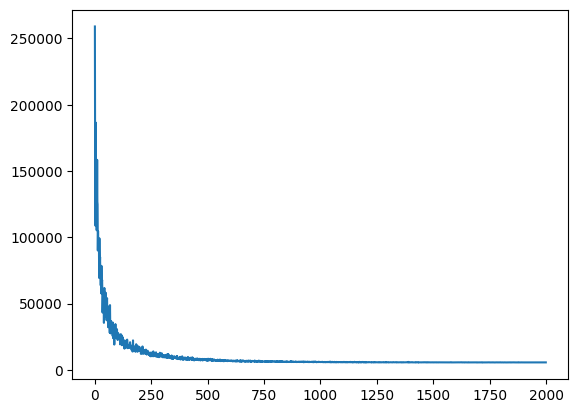

/home/rafal/s78projects/cities/cities/modeling/zoning_models/zoning_tracts_sqm_model.py:58: UserWarning: Passed categorical_levels will no longer override the levels passed to or computed during model initialization. The argument will be ignored.
  warnings.warn(


tensor(0.3265) tensor(0.2152)


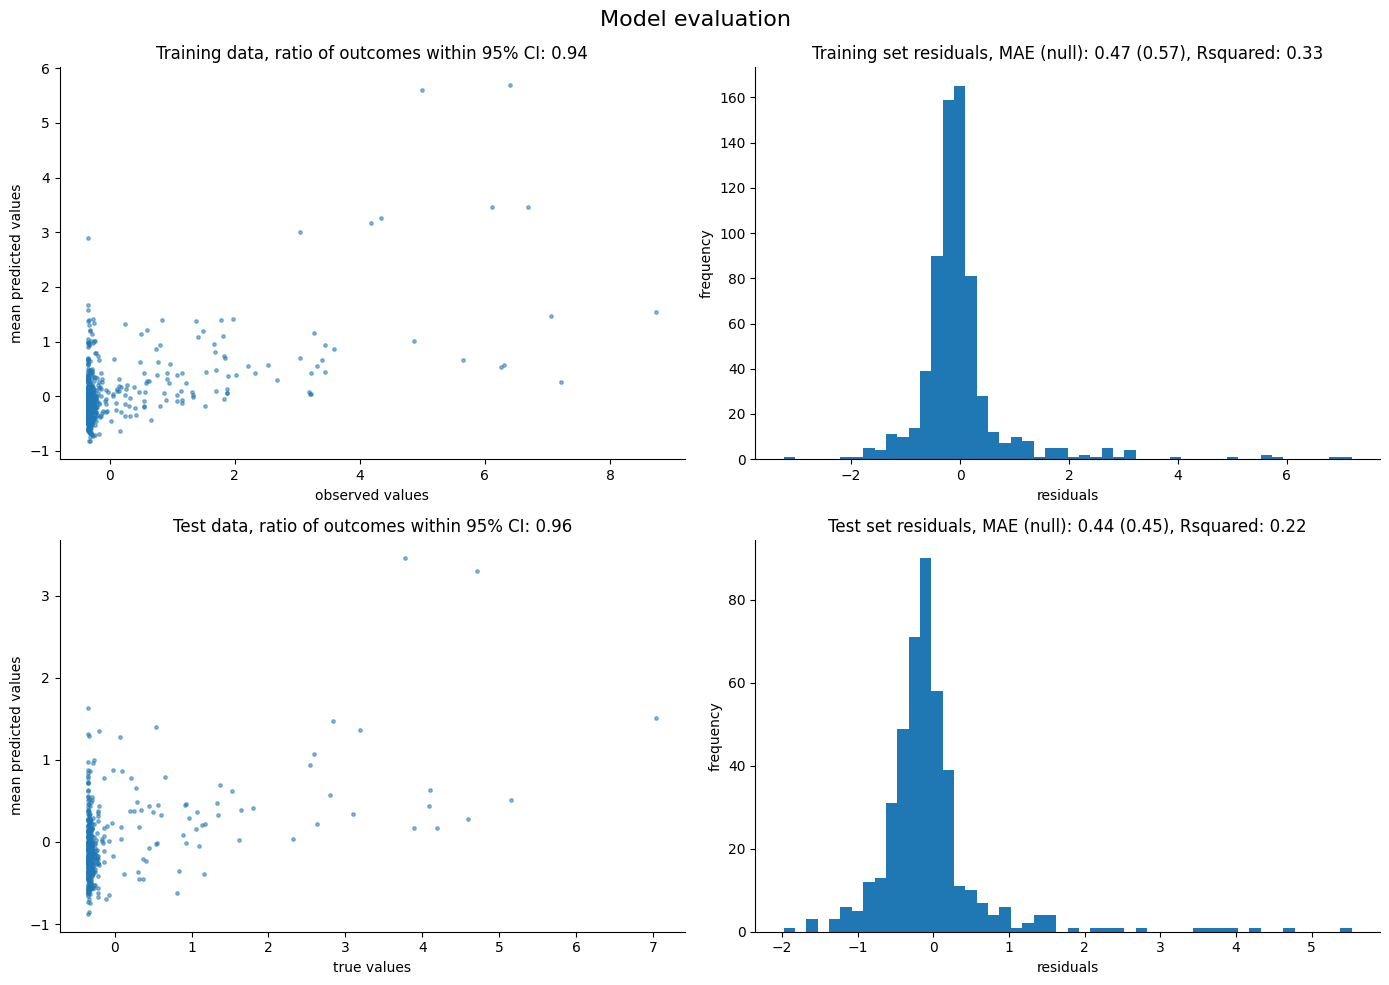

In [6]:
test_sqm = False

if test_sqm:

    pyro.clear_param_store()

    train_loader, test_loader, categorical_levels = prep_data_for_test(
        census_tracts_data_path, train_size=0.6
    )

    sqm_performance_results = test_performance(
        sqm_model,
        kwargs,
        train_loader,
        test_loader,
        categorical_levels,
        outcome_type="continuous",
        outcome_name="housing_units",
        n_steps=n_steps,
        plot=True,
        is_class=False,
    )


sqm_mae_improvement_train = destandardize_housing_units(
    sqm_performance_results["mae_null_train"] - sqm_performance_results["mae_train"]
)
sqm_mae_improvement_test = destandardize_housing_units(
    sqm_performance_results["mae_null_test"] - sqm_performance_results["mae_test"]
)

print(
    f"MAE improvements on the original scale (sqm model): {sqm_mae_improvement_test, sqm_mae_improvement_train}"
)

We can also compute mean absolute error improvement over the null model in the original scale of housing units per census tract.

MAE improvements on the original scale (sqm model): (tensor(32.), tensor(41.))


In [23]:
# now we train the model with the full dataset
# cache the guide and the parameters

file_path = os.path.join(root, "data/minneapolis/guides", f"tracts_sqm_model_guide_pg.pkl")
param_path = os.path.join(
        root, "data/minneapolis/guides", "tracts_sqm_model_params_pg.pth"
    )

if not os.path.exists(file_path) or not os.path.exists(param_path):
    pyro.clear_param_store()
    sqm_guide = run_svi_inference(
        sqm_model,
        subset,
        n_steps=n_steps,
        num_samples=num_samples,
        smoke_test=smoke_test,
    )

    serialized_guide = dill.dumps(sqm_guide)
    with open(file_path, "wb") as file:
        file.write(serialized_guide)

    pyro.get_param_store().save(param_path)

else:
    pyro.clear_param_store()
    with open(file_path, "rb") as file:
        sqm_guide = dill.load(file)

    pyro.get_param_store().save(param_path)

We can now evaluate the train model by computing its Widely Acceptable Information Criterion score (WAIC):

In [24]:
waic_sqm = compute_waic(
    model=sqm_model,
    guide=sqm_guide,
    num_particles=10000,
    sites=["housing_units"],
    max_plate_nesting=9,
    **subset,
)

print(waic_sqm['waic'], waic_sqm['p_waic'])

tensor(2920.1685, grad_fn=<MulBackward0>) tensor(44.4182, grad_fn=<SumBackward0>)


In [25]:
sqm_predictive = Predictive(sqm_model, guide=sqm_guide, num_samples=num_samples, parallel=True)
sqm_preds = sqm_predictive(**subset_for_preds)


The model's performance, however, is not great downtown and in the university area. Part of the reason is that the regulations for those areas were quite different and they were were not directly impacted by the parking reform. Let's inspect residuals.

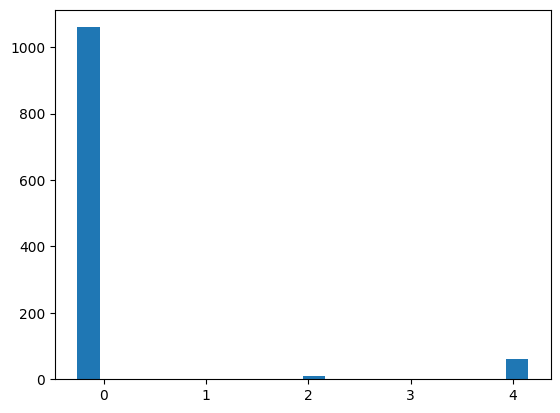

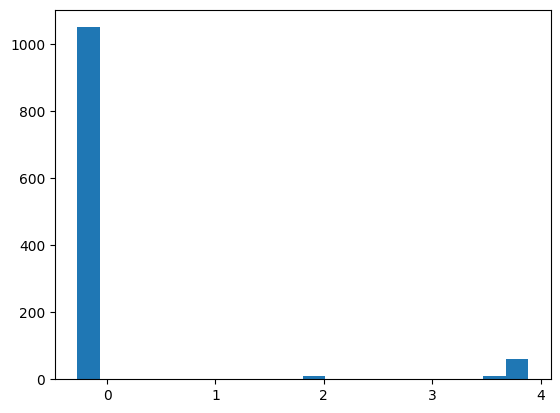

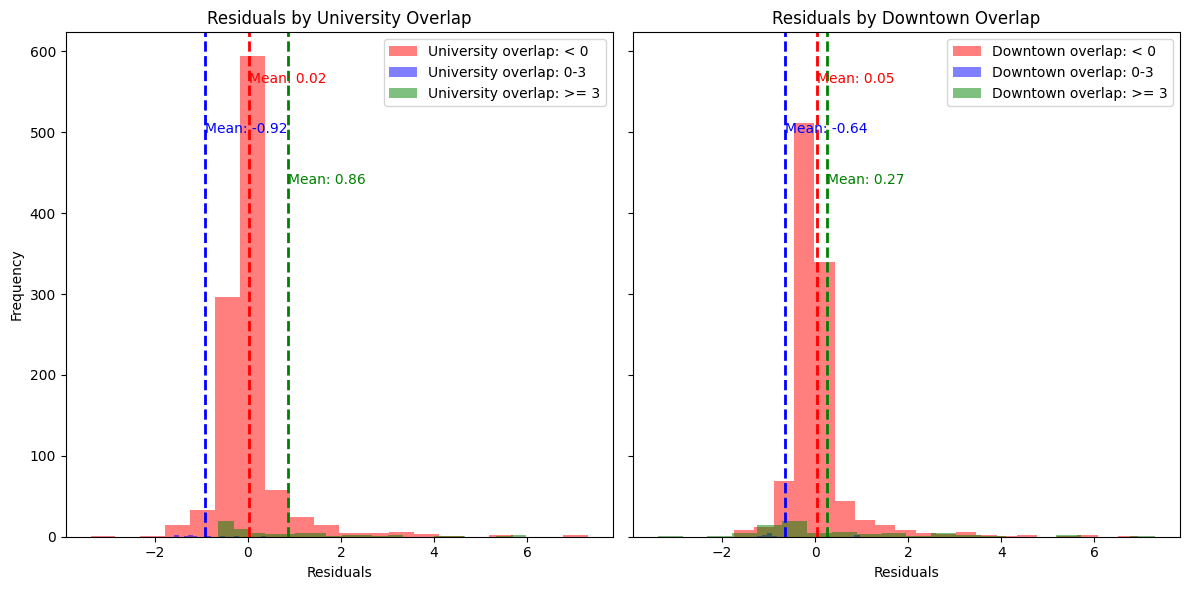

In [26]:
# first some data wrangling to get the residuals

university_overlap = subset['continuous']['university_overlap'].detach().numpy()
downtown_overlap = subset['continuous']['downtown_overlap'].detach().numpy()
units_observed = subset['continuous']['housing_units'].detach().numpy()
units_observed_original = subset['continuous']['housing_units_original'].detach().numpy()

null_residuals = units_observed  - np.mean(units_observed)

sqm_units_predicted = sqm_preds['housing_units'].mean(dim = 0).detach().numpy()

sqm_residuals = units_observed - sqm_units_predicted


# Note there are roughly three clusters for each of the overlap variables
plt.hist(university_overlap, bins = 20)
plt.show()

plt.hist(downtown_overlap, bins = 20)
plt.show()

bins = [-np.inf, 0, 3, np.inf]  # Representing university_overlap < 0, 
# 0 < university_overlap < 3, and university_overlap >= 3
bin_labels = ['< 0', '0-3', '>= 3']

university_bin_indices = np.digitize(university_overlap, bins=bins) - 1 
downtown_bin_indices = np.digitize(downtown_overlap, bins=bins) - 1

def plot_residuals_by_overlap(residuals):


    grouped_residuals_university = [residuals[university_bin_indices == i] for i in range(len(bins) - 1)]
    grouped_residuals_downtown = [residuals[downtown_bin_indices == i] for i in range(len(bins) - 1)]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    colors = ['red', 'blue', 'green']

    y_offsets = [0.9, 0.8, 0.7]  # Adjust as needed

    for i in range(len(bin_labels)):
        axes[0].hist(grouped_residuals_university[i], bins=20, alpha=0.5, label=f"University overlap: {bin_labels[i]}", color=colors[i])
        
        mean_university = np.mean(grouped_residuals_university[i])
        axes[0].axvline(mean_university, color=colors[i], linestyle='dashed', linewidth=2)
        
        y_position = axes[0].get_ylim()[1] * y_offsets[i]
        axes[0].text(mean_university, y_position, f'Mean: {mean_university:.2f}', color=colors[i])

    axes[0].set_title("Residuals by University Overlap")
    axes[0].set_xlabel("Residuals")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()

    for i in range(len(bin_labels)):
        axes[1].hist(grouped_residuals_downtown[i], bins=20, alpha=0.5, label=f"Downtown overlap: {bin_labels[i]}", color=colors[i])
        
        mean_downtown = np.mean(grouped_residuals_downtown[i])
        axes[1].axvline(mean_downtown, color=colors[i], linestyle='dashed', linewidth=2)
        
        y_position = axes[1].get_ylim()[1] * y_offsets[i]
        axes[1].text(mean_downtown, y_position, f'Mean: {mean_downtown:.2f}', color=colors[i])

    axes[1].set_title("Residuals by Downtown Overlap")
    axes[1].set_xlabel("Residuals")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


plot_residuals_by_overlap(sqm_residuals)

So we add two features: standardized ratio of downtown (university, respectively), overlap. Moreover, we considered adding pairwise interactions to the parents of `housing_units`. We proceeded as follows:

0. Start with adding all possible pairwise interactions. The resulting WAIC is around 4000, performance increases dramatically for the trainining set and drops to $R^2$ of around .18 on the validation set. We're clearly overfitting.
   
1. Start with a minimal plausible list that contains the overlap, distance and limit variables: 
   ```
   ins = [("university_overlap", "limit"),
    ("downtown_overlap", "limit"),
    ("distance", "downtown_overlap"),
    ("distance", "university_overlap"),
    ("distance", "limit"),]
    ```

2. Generate a list of all possible pairwise interactions, `list`. For each `l` in `list`, add `l` to `ins`, train the resulting model for 800 iterations, compute WAIC. From the resulting list of WAIC scores pick three lowest, add the corresponding pairs to interactions.

3. Train the resulting model for 2000 iterations, compute WAIC. If lower than the original WAIC score, and performance on the train-validation split doesn't decrease, keep.

Three iterations led to a situation with no further improvement, resulting in the following list of interactions:  

In [27]:
ins = [
    ("university_overlap", "limit"),
    ("downtown_overlap", "limit"),
    ("distance", "downtown_overlap"),
    ("distance", "university_overlap"),
    ("distance", "limit"),
    ('median_value', 'segregation'),
    ('distance', 'segregation'),
    ('limit', 'sqm'),
    ('segregation', 'sqm'),
    ('distance', 'white'),
    ('income', 'limit'),
    ('downtown_overlap', 'median_value'),
    ('downtown_overlap', 'segregation'),
    ('median_value', 'white'),
    ('distance', 'income'),
]

In [28]:
from cities.modeling.zoning_models.zoning_tracts_continuous_interactions_model import TractsModelContinuousInteractions

pyro.clear_param_store()

interactions_model = TractsModelContinuousInteractions(
    **subset,
    housing_units_continuous_interaction_pairs = ins,
    limit_continuous_interaction_pairs= [("distance", "university_overlap"), ("distance", "downtown_overlap")],
)

with pyro.poutine.trace() as tr:
    interactions_model(**subset)


assert tr.trace.nodes["housing_units"]["value"].shape == torch.Size([1130])

with pyro.poutine.trace() as tr_unconditioned:
    interactions_model(**subset_for_preds)


pyro.render_model(
    lambda: interactions_model(**subset),
    render_deterministic=True,
    filename = "interactions_model.png"
)

RuntimeError: Multiple sample sites named 'distance_x_downtown_overlap'

/home/rafal/s78projects/cities/cities/modeling/evaluation.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  zoning_dataset_read = torch.load(data_path)


[iteration 0001] loss: 206917.6094
[iteration 0050] loss: 41271.0664
[iteration 0100] loss: 22104.4062
[iteration 0150] loss: 16952.3730
[iteration 0200] loss: 14036.4707
[iteration 0250] loss: 11911.9053
[iteration 0300] loss: 12161.0488
[iteration 0350] loss: 9213.8037
[iteration 0400] loss: 9333.4287
[iteration 0450] loss: 9222.1426
[iteration 0500] loss: 8146.3242
[iteration 0550] loss: 7780.0806
[iteration 0600] loss: 7898.3740
[iteration 0650] loss: 7770.4175
[iteration 0700] loss: 7547.9922
[iteration 0750] loss: 7280.3647
[iteration 0800] loss: 7174.8696
[iteration 0850] loss: 7237.9409
[iteration 0900] loss: 7094.6216
[iteration 0950] loss: 7126.7656
[iteration 1000] loss: 6997.7686
[iteration 1050] loss: 6972.0298
[iteration 1100] loss: 6914.2910
[iteration 1150] loss: 6872.5103
[iteration 1200] loss: 6807.3848
[iteration 1250] loss: 6902.9360
[iteration 1300] loss: 6761.4502
[iteration 1350] loss: 6766.7969
[iteration 1400] loss: 6743.4316
[iteration 1450] loss: 6742.0967
[i

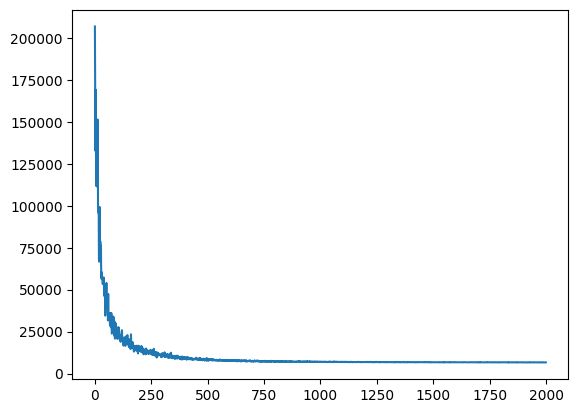

/home/rafal/s78projects/cities/cities/modeling/zoning_models/zoning_tracts_continuous_interactions_model.py:63: UserWarning: Passed categorical_levels will no longer override the levels passed to or computed during model initialization. The argument will be ignored.
  warnings.warn(


tensor(0.5349) tensor(0.2039)


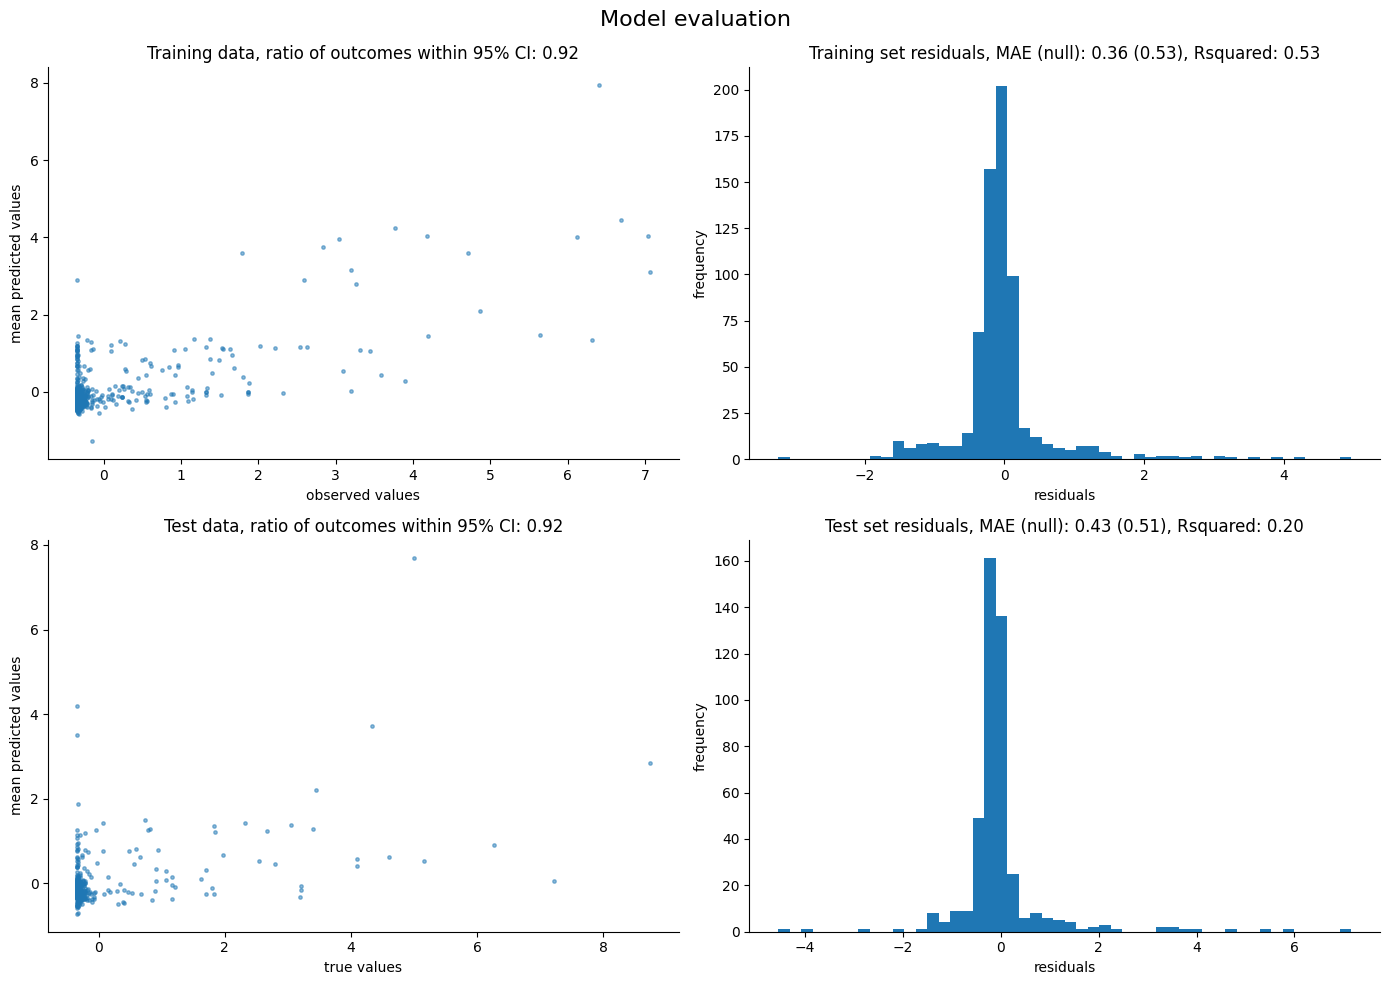

MAE improvements on the original scale: (tensor(38.), tensor(46.))


In [15]:
#evaluate performance, compute improvement in the original scale.

pyro.clear_param_store()


train_loader, test_loader, categorical_levels = prep_data_for_test(
    census_tracts_data_path, train_size=0.6
)

performance_results = test_performance(
    interactions_model,
    kwargs,
    train_loader,
    test_loader,
    categorical_levels,
    outcome_type="continuous",
    outcome_name="housing_units",
    n_steps=n_steps,
    plot=True,
    is_class=False,
)

mae_improvement_train = destandardize_housing_units(
    performance_results["mae_null_train"] - performance_results["mae_train"]
)
mae_improvement_test = destandardize_housing_units(
    performance_results["mae_null_test"] - performance_results["mae_test"]
)

print(
    f"MAE improvements on the original scale: {mae_improvement_test, mae_improvement_train}"
)

[iteration 0001] loss: 281147.9375
[iteration 0050] loss: 24039.4824
[iteration 0100] loss: 15878.7275
[iteration 0150] loss: 14657.1777
[iteration 0200] loss: 12382.4961
[iteration 0250] loss: 12254.0117
[iteration 0300] loss: 11648.2461
[iteration 0350] loss: 11557.4014
[iteration 0400] loss: 11311.8281
[iteration 0450] loss: 11237.2275
[iteration 0500] loss: 11160.7139
[iteration 0550] loss: 11029.9951
[iteration 0600] loss: 11010.4238
[iteration 0650] loss: 11064.5498
[iteration 0700] loss: 10950.8486
[iteration 0750] loss: 10877.3242
[iteration 0800] loss: 10985.2959
[iteration 0850] loss: 10862.1328
[iteration 0900] loss: 10849.9346
[iteration 0950] loss: 10861.6455
[iteration 1000] loss: 10745.4287
[iteration 1050] loss: 10755.6279
[iteration 1100] loss: 10758.9717
[iteration 1150] loss: 10682.7988
[iteration 1200] loss: 10699.3330
[iteration 1250] loss: 10650.9990
[iteration 1300] loss: 10665.2871
[iteration 1350] loss: 10694.0293
[iteration 1400] loss: 10673.1738
[iteration 14

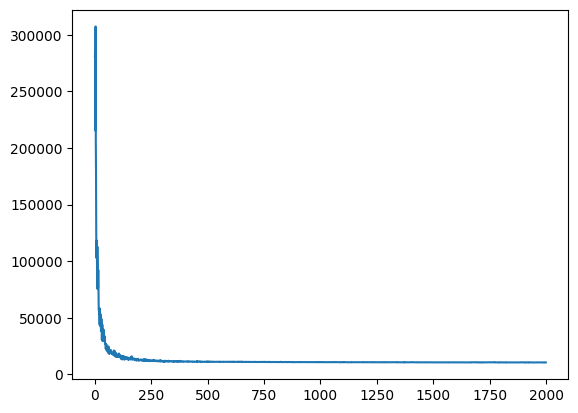

In [16]:
# train the model with the full dataset
# cache the guide and the parameters

fresh_train = True

pyro.clear_param_store()

interactions_file_path = os.path.join(root, "data/minneapolis/guides", f"tracts_interactions_model_guide_pg.pkl")
interactions_param_path = os.path.join(
        root, "data/minneapolis/guides", "tracts_interactions_model_params_pg.pth"
    )

if fresh_train or not os.path.exists(interactions_file_path) or not os.path.exists(interactions_param_path):
    pyro.clear_param_store()
    interactions_guide = run_svi_inference(interactions_model, n_steps=n_steps, lr=0.03, **subset)

    serialized_guide = dill.dumps(interactions_guide)
    with open(interactions_file_path, "wb") as file:
        file.write(serialized_guide)

    pyro.get_param_store().save(interactions_param_path)

else:
    print("loading guide and params for the interactions model")
    pyro.clear_param_store()
    with open(interactions_file_path, "rb") as file:
        interactions_guide = dill.load(file)
        

    pyro.get_param_store().save(param_path)

In [17]:
waic_interaction = compute_waic(
    model=interactions_model,
    guide=interactions_guide,
    num_particles=10000,
    sites=["housing_units"],
    max_plate_nesting=9,
    **subset,
)

print(waic_interaction['waic'], waic_interaction['p_waic'])

tensor(2756.3044, grad_fn=<MulBackward0>) tensor(55.2238, grad_fn=<SumBackward0>)


In [18]:
interactions_predictive = Predictive(interactions_model, guide=interactions_guide, 
                                        num_samples=1000, parallel=True)
interactions_preds = interactions_predictive(**subset_for_preds)
interactions_preds_units = interactions_preds['housing_units'].mean(dim=0).detach().numpy()
interactions_preds_units_original = destandardize_housing_units(
        interactions_preds['housing_units']).mean(dim = 0).clamp(min =0).detach().numpy()

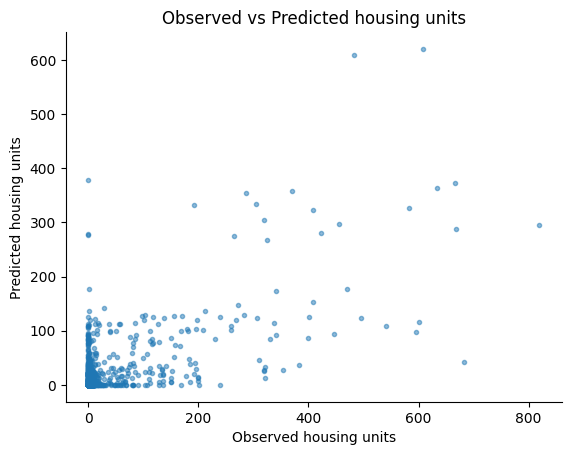

In [19]:
plt.scatter(y = interactions_preds_units_original,
             x = units_observed_original, s= 9, alpha = .5)
plt.xlabel("Observed housing units")
plt.ylabel("Predicted housing units")
plt.title("Observed vs Predicted housing units")
sns.despine()
plt.show()

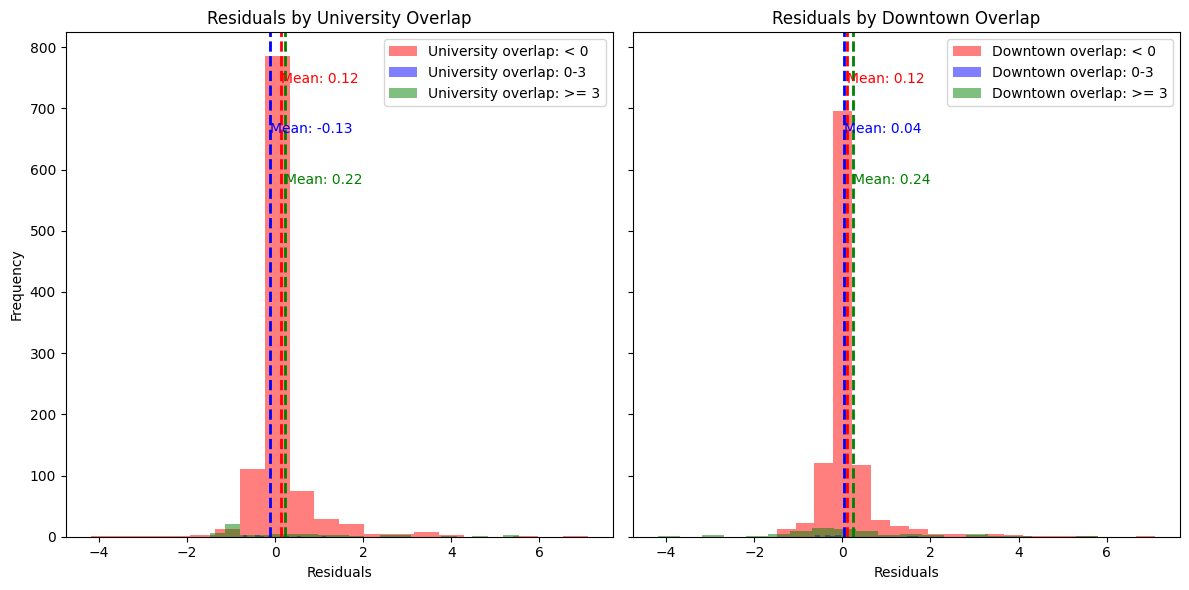

In [21]:
# we repeat looking at the residuals by downtown and university overlap
# to see if the model has improved

interactions_residuals = units_observed - interactions_preds_units
# there are still some factors downtown and university that we're not capturing, but 
# performance is much better there
plot_residuals_by_overlap(interactions_residuals)

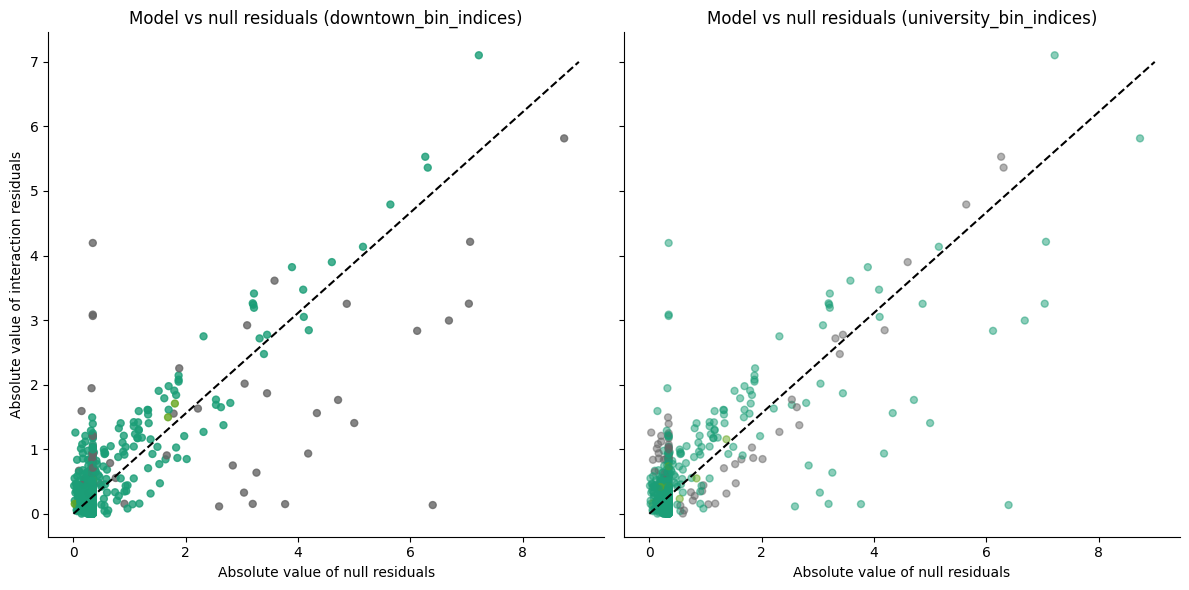

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)


axes[0].scatter(x=abs(null_residuals), y=abs(interactions_residuals),
                 s=25, alpha=0.8, c=downtown_bin_indices, cmap = 'Dark2')
axes[0].set_xlabel("Absolute value of null residuals")
axes[0].set_ylabel("Absolute value of interaction residuals")
axes[0].plot([0, 9], [0, 7], 'k--')
axes[0].set_title("Model vs null residuals (downtown_bin_indices)")

axes[1].scatter(x=abs(null_residuals), y=abs(interactions_residuals), 
                s=25, alpha=0.5, c=university_bin_indices, cmap = "Dark2")
axes[1].set_xlabel("Absolute value of null residuals")
axes[1].plot([0, 9], [0, 7], 'k--')
axes[1].set_title("Model vs null residuals (university_bin_indices)")

plt.tight_layout()
sns.despine()
plt.show()

Now we want to inspect pointwise change in posterior variances: we observe overall tightening of the posteriors, with a bit more unexplained variance at the university grounds.

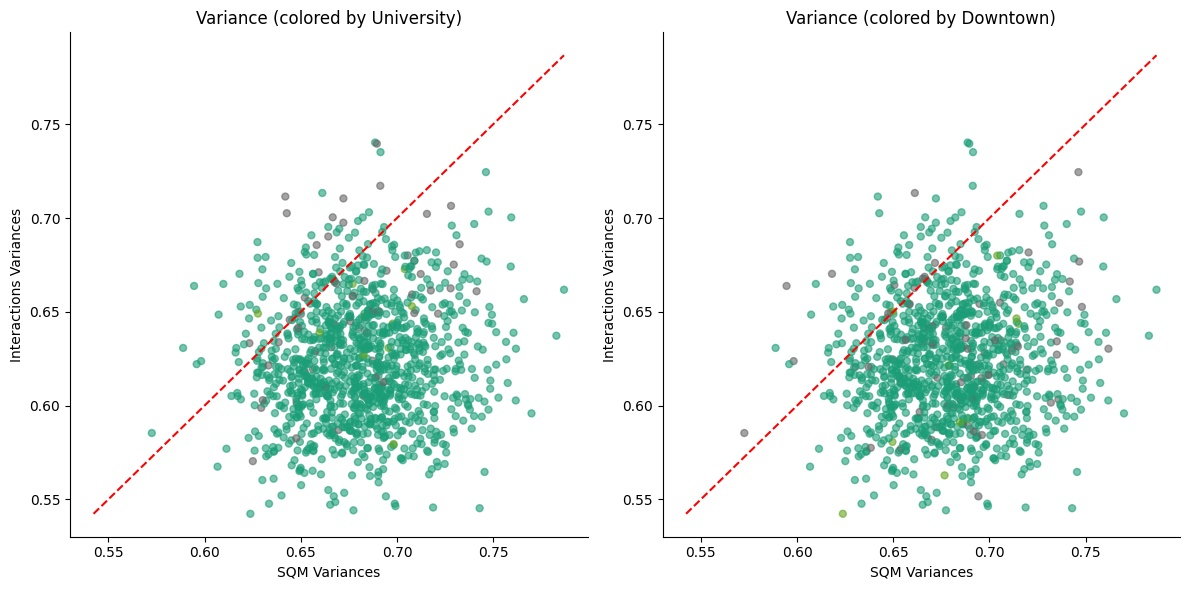

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

# by University - a bit more variance, but much better than before
sqm_variances = sqm_preds['housing_units'].var(dim=0)
interactions_variances = interactions_preds['housing_units'].var(dim=0)

scatter1 = axes[0].scatter(x=sqm_variances, y=interactions_variances, 
                           c=university_bin_indices, s=25, alpha=0.6,
                           cmap = "Dark2")
min_val = min(sqm_variances.min(), interactions_variances.min())
max_val = max(sqm_variances.max(), interactions_variances.max())
axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

axes[0].set_xlabel("SQM Variances")
axes[0].set_ylabel("Interactions Variances")
axes[0].set_title("Variance (colored by University)")

#by Downtown
scatter2 = axes[1].scatter(x=sqm_variances, y=interactions_variances, 
                           c=downtown_bin_indices, s=25, alpha=0.6,
                           cmap = "Dark2")
min_val = min(sqm_variances.min(), interactions_variances.min())
max_val = max(sqm_variances.max(), interactions_variances.max())
axes[1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

axes[1].set_xlabel("SQM Variances")
axes[1].set_ylabel("Interactions Variances")
axes[1].set_title("Variance (colored by Downtown)")
sns.despine()
plt.tight_layout()


plt.show()


In [25]:
# count extreme prediction failures, cases where obs are beyond 99% intervals

sqm_quantiles = sqm_preds['housing_units'].quantile(torch.tensor([0.005, 0.995]), dim=0)


sqm_outliers_below = (torch.tensor(units_observed) < sqm_quantiles[0,:]).sum()
sqm_outliers_above = (torch.tensor(units_observed) > sqm_quantiles[1,:]).sum()


print(sqm_outliers_below, sqm_outliers_above, (sqm_outliers_below + sqm_outliers_above)/units_observed.shape[-1])    

interactions_quantiles = interactions_preds['housing_units'].quantile(torch.tensor([0.005, 0.995]), dim=0)

interaction_outliers_below = (torch.tensor(units_observed) < interactions_quantiles[0,:]).sum()
interaction_outliers_above = (torch.tensor(units_observed) > interactions_quantiles[1,:]).sum()

print(interaction_outliers_below, interaction_outliers_above, (interaction_outliers_below + interaction_outliers_above)/units_observed.shape[-1])

# there are approx 3% cases where the predictions 
# are widely off


tensor(1) tensor(34) tensor(0.0310)
tensor(3) tensor(30) tensor(0.0292)
